In [1]:
from google.cloud import vision
from pdf2image import convert_from_path
from PIL import Image, ImageDraw, ImageFont
import io
import fitz  # PyMuPDF
import os
from xml.sax.saxutils import escape


In [2]:
client = vision.ImageAnnotatorClient()

I0000 00:00:1731861238.052676  353081 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


In [3]:
def build_processed_pdf(directory, filename):
    pil_images = []
    text_pages = []
    word_locations_list = []

    file_path = os.path.join(directory, filename)
    print(f"beginning to process: {file_path}")

    # Load PDF and extract image bytes from a given page
    doc = fitz.open(file_path)

    for page_num in range(doc.page_count):
        print(f"processing page: {page_num}...")
        
        page = doc.load_page(page_num)  # Load the first page
        images = page.get_images(full=True)
        xref = images[0][0]  # Get the first image reference
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]  # Get the raw JPEG byte content

        # Convert to PIL Image for further processing if needed
        p_image = Image.open(io.BytesIO(image_bytes))
        pil_images.append(p_image)

        # Annotate with vision
        image = vision.Image(content=image_bytes)
        response = client.text_detection(image=image)
        text_annotations = response.text_annotations

        # Build labeled image
        font_size = 15  
        font_path="/System/Library/Fonts/Supplemental/Arial.ttf"
        font = ImageFont.truetype(font_path, font_size)

        draw = ImageDraw.Draw(p_image)
        for i, text_obj in enumerate(text_annotations):
            # Get the bounding box vertices
            vertices = [(vertex.x, vertex.y) for vertex in text_obj.bounding_poly.vertices]

            # Draw a polygon based on the bounding box
            if len(vertices) == 4:
                draw.polygon(vertices, outline="red", width=2)
                if i > 0: # first bounding box is whole text region
                    draw.text(vertices[0], text_obj.description, fill="red", font=font)

        full_page_text = text_annotations[0].description  # always the first text_annotation object
        word_locations = text_annotations[1:]
        word_locations_list.append(word_locations)
        text_pages.append(full_page_text)

    return text_pages, word_locations_list, pil_images

In [4]:
import os
import json

def save_annotated_text_and_image_data(root_dir, data_location, text_data, image_data):
    """
    Creates a directory structure to save images, text data, and an HTML gallery for viewing.
    
    Parameters:
        root_dir (str): The root directory to store data.
        data_location (str): Directory location under root_dir for storing files.
        text_data (list of str): List of extracted text for each page.
        image_data (list of tuples): List of tuples, where each tuple contains the image filename (str) 
                                     and the image data (as bytes or PIL image).
                                     
    """
    # Create directory paths
    base_dir = os.path.join(root_dir, data_location)
    os.makedirs(base_dir, exist_ok=True)

    images_dir = os.path.join(base_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    
    # File paths for JSONL and HTML files
    jsonl_file_path = os.path.join(base_dir, "extracted_text.jsonl")
    html_file_path = os.path.join(base_dir, "index.html")
    
    # Step 1: Save text data to JSONL
    with open(jsonl_file_path, "w", encoding="utf-8") as jsonl_file:
        for i, text in enumerate(text_data):
            entry = {
                "image": f"images/page{i+1}.jpg",  # Image filename
                "text": text
            }
            jsonl_file.write(json.dumps(entry) + "\n")
    
    # Step 2: Save images to the images directory
    for i, img in enumerate(image_data):
        image_path = os.path.join(images_dir, f"page{i+1}.jpg")
        img.save(image_path, format="JPEG")
    
    # Step 3: Generate HTML file for viewing
    with open(html_file_path, "w", encoding="utf-8") as html_file:
        html_file.write("<html><head><title>Annotated Image Gallery</title></head><body>\n")
        html_file.write("<h1>Annotated Image Gallery</h1>\n")
        
        for i, text in enumerate(text_data):
            img_filename = f"images/page{i+1}.jpg"
            html_file.write("<div class='image-entry'>\n")
            html_file.write(f"  <img src='{img_filename}' alt='Page {i+1}' style='width:100%; max-width:600px;'>\n")
            html_file.write(f"  <textarea readonly style='width:100%; height:150px;'>{text}</textarea>\n")
            html_file.write("</div><br>\n")
        
        html_file.write("</body></html>")

    print(f"Data successfully saved in {base_dir}")

# Example usage:
# save_annotated_text_and_image_data(root_dir="my_data", data_location="ocr_project", text_data=["text1", "text2"], image_data=[("img1.jpg", img_bytes), ("img2.jpg", img_bytes)])

In [5]:
import os

def save_xml_text_file(root_dir, title_file, text_data):
    """
    Generates and saves an XML file with a title and pages, where each page contains text data.
    
    Parameters:
        root_dir (str): The root directory where the XML file will be saved.
        title_file (str): The title to be used in the XML file and filename.
        text_data (list of str): List of extracted text for each page.
    """
    # Define the XML file path
    xml_file_path = os.path.join(root_dir, title_file, f"full_OCR_text_{title_file}.xml")
    os.makedirs(os.path.dirname(xml_file_path), exist_ok=True)
    
    # Start writing the XML file
    with open(xml_file_path, "w", encoding="utf-8") as xml_file:
        # Write XML declaration and root element with title
        xml_file.write("<?xml version='1.0' encoding='UTF-8'?>\n")
        xml_file.write(f"<document>\n  <title>{escape(title_file)}</title>\n")
        
        # Add each page with its content, escaping the text for XML safety
        for i, text in enumerate(text_data):
            # Escape text content to handle special characters
            escaped_text = escape(text)
            # Write each page as <page page="1">...</page>
            xml_file.write(f"  <page page='{i+1}'>\n")
            xml_file.write(f"    {escaped_text}\n")
            xml_file.write("  </page>\n")
        
        # Close the root element
        xml_file.write("</document>")

    print(f"XML file successfully saved at {xml_file_path}")

In [6]:
def full_pdf_process(pdf_dir, pdf_filename, output_dir):
    current_title, ext = os.path.splitext(pdf_filename)
    assert ext == ".pdf", f"Expected .pdf, got {ext}"
    text_pages, marked_images = build_processed_pdf(pdf_dir, pdf_filename)
    save_annotated_text_and_image_data(output_dir, current_title, text_pages, marked_images)
    save_xml_text_file(output_dir, current_title, text_pages)
    return text_pages, marked_images


In [7]:
# directory to read pdfs from
pdf_dir = "../PDF/Phat_Giao_journals"

# directory to save output
output_dir = "../processed_journal_data"

In [8]:
text, words, images = build_processed_pdf(pdf_dir, "phat-giao-viet-nam-1956-25-26.pdf")

beginning to process: ../PDF/Phat_Giao_journals/phat-giao-viet-nam-1956-25-26.pdf
processing page: 0...
processing page: 1...
processing page: 2...
processing page: 3...
processing page: 4...
processing page: 5...
processing page: 6...
processing page: 7...
processing page: 8...
processing page: 9...
processing page: 10...
processing page: 11...
processing page: 12...
processing page: 13...
processing page: 14...
processing page: 15...
processing page: 16...
processing page: 17...
processing page: 18...
processing page: 19...
processing page: 20...
processing page: 21...
processing page: 22...
processing page: 23...
processing page: 24...
processing page: 25...
processing page: 26...
processing page: 27...


In [39]:
images[0].size

(1024, 1536)

In [21]:
words[0][0]

description: "PHẬT"
bounding_poly {
  vertices {
    x: 132
    y: 124
  }
  vertices {
    x: 552
    y: 124
  }
  vertices {
    x: 552
    y: 308
  }
  vertices {
    x: 132
    y: 308
  }
}

In [22]:
type(words[0][0])

EntityAnnotation

In [34]:
text[3]

'PHẬT-GIÁO VIỆT-NAM\nBƯỚC SANG NĂM THỨ BA\n| ới số 25 và 26 Phật giáo Việt Nam Nguyệt san bước\nsang năm thứ ba\nTrước khi bước những bước tiến mới, chúng ta hãy tạm\ndừng lại, nhìn lui con đường vừa qua để rút những bài học kinh\nnghiệm ngõ hầu tiến tới một cách mạnh mẽ, tránh những vấp ngã\nvà tiền đúng với mục tiêu đã nêu lên.\ngom\nSau mấy tháng điều tra dư luận độc giả, chúng tôi đã\ngóp được một mớ ý-kiểu về Nguyệt-san Phật-giáo Việt-Nam như sau:\nMột số độc giả than phiền rằng nội-dung của «Phật giáo\nViệt Nam quả cô đọng, chất-hẹp, chỉ quanh – quẩn trong phạm vi\nĐạo Phật, nên không thể phổ biến rộng ra ngoài được, mà chỉ dành\nriêng cho một số Phật tử thuần thành. Điều ấy quả có như thế. Mặc\ndù chúng tôi đã cố gắng mở rộng phạm vi nhưng không thể mở toang\nbiên giới của nó được, vì cái tên «Phật-giáo Việt-Nam đã đóng\nkhung nó lại rồi. Mỗi tạp chí đều có một chủ trương, một nội dung,\nmột mục-đích riêng biệt mà cái tên, là cái nhãn hiệu, đã nói lên một\nphần nào cái tinh thần

In [ ]:
def convert_page_words(word_info):
    
    converted_info = []
    for word in word_info:
        text = word.description
        x = [vertex.x for vertex in word.bounding_poly.vertices]
        y = [vertex.y for vertex in word.bounding_poly.vertices]
        assert len(x) == 4, "not four pointed bounding box."

        width_bottom = x[1] - x[0] # point order is: bottom-left, bottom-right, top-right, top-left
        width_top = x[2] - x[3]
        height_left = y[3] - y[0]
        height_right = y[2] - y[1] # this according to the layout of bounding poly

        if width_bottom != width_top:
            print(f"Warning bounding box width mismatch for: {text}, skipping.")
            continue
        if height_left != height_right:
            print(f"Warning bounding box height mismatch for: {text}, skipping.")
            continue
        
        new_info = [text, (x[0], y[0]), width_bottom, height_left]
        converted_info.append(new_info)
    
    return converted_info

In [16]:
new_info = convert_page_words(words[3])

Warning bounding box width mismatch for: TH, skipping.
Warning bounding box width mismatch for: HAN, skipping.


In [17]:
new_info

[['PHẬT', (170, 250), 176, 94],
 ['-', (352, 250), 14, 94],
 ['GIÁO', (372, 250), 168, 94],
 ['VIỆT', (564, 250), 146, 94],
 ['-', (707, 250), 18, 94],
 ['NAM', (730, 250), 152, 94],
 ['BƯỚC', (278, 364), 108, 72],
 ['SANG', (408, 364), 94, 72],
 ['NĂM', (524, 364), 76, 72],
 ['THỨ', (622, 364), 80, 72],
 ['BA', (722, 364), 46, 72],
 ['|', (237, 496), 16, 61],
 ['ới', (273, 496), 32, 61],
 ['số', (313, 496), 23, 61],
 ['25', (344, 496), 27, 61],
 ['và', (388, 496), 21, 61],
 ['26', (422, 496), 27, 61],
 ['Phật', (470, 496), 45, 61],
 ['giáo', (525, 496), 45, 61],
 ['Việt', (589, 496), 45, 61],
 ['Nam', (637, 496), 62, 61],
 ['Nguyệt', (717, 496), 71, 61],
 ['san', (807, 496), 26, 61],
 ['bước', (851, 496), 49, 61],
 ['sang', (147, 567), 47, 30],
 ['năm', (207, 564), 44, 29],
 ['thứ', (266, 560), 36, 29],
 ['ba', (318, 557), 19, 30],
 ['Trước', (239, 606), 71, 31],
 ['khi', (324, 606), 33, 31],
 ['bước', (372, 606), 52, 31],
 ['những', (440, 606), 67, 31],
 ['bước', (521, 606), 52, 31],

In [29]:
def collate_lines(words):
    """
    Collate OCR words into lines based on y-coordinates and line height, 
    assuming the words are already sorted by their y-coordinates.

    Args:
        words (list): List of words with their positions and dimensions 
                      in the form [text, (x, y), width, height].
    
    Returns:
        list: Collated lines in the form 
              [text_line, (start_x, start_y), (end_x, start_y), line_height].
    """
    if not words:
        return []
    
    # Sort words by y-coordinate (descending for top-to-bottom layout)
    # words = sorted(words, key=lambda w: (w[1][1], w[1][0]))
        
    collated_lines = []
    current_line = []
    current_y = words[0][1][1]
    current_height = words[0][3]

    for word in words:
        text, (x, y), width, height = word
        # Calculate tolerance for y-coordinate based on current line height
        tolerance = current_height * 0.5
        
        # Check if the word fits in the current line
        if abs(y - current_y) <= tolerance:
            current_line.append(word)
        else:
            # Finalize the current line
            if current_line:
                line_text = " ".join(w[0] for w in current_line)
                start_x = current_line[0][1][0]
                start_y = current_line[0][1][1]
                end_x = current_line[-1][1][0] + current_line[-1][2]
                collated_lines.append([line_text, (start_x, start_y), (end_x, start_y), current_height])
            
            # Start a new line
            current_line = [word]
            current_y = y
            current_height = height
    
    # Add the last line
    if current_line:
        line_text = " ".join(w[0] for w in current_line)
        start_x = current_line[0][1][0]
        start_y = current_line[0][1][1]
        end_x = current_line[-1][1][0] + current_line[-1][2]
        collated_lines.append([line_text, (start_x, start_y), (end_x, start_y), current_height])
    
    return collated_lines

In [30]:
collate_lines(new_info)

[['PHẬT - GIÁO VIỆT - NAM', (170, 250), (882, 250), 94],
 ['BƯỚC SANG NĂM THỨ BA', (278, 364), (768, 364), 72],
 ['| ới số 25 và 26 Phật giáo Việt Nam Nguyệt san bước',
  (237, 496),
  (900, 496),
  61],
 ['sang năm thứ ba', (147, 567), (337, 567), 30],
 ['Trước khi bước những bước tiến mới , chúng ta hãy tạm',
  (239, 606),
  (899, 606),
  31],
 ['dừng lại , nhìn lui con đường vừa qua để rút những bài học kinh',
  (147, 645),
  (898, 645),
  33],
 ['nghiệm ngõ hầu tiến tới một cách mạnh mẽ , tránh những vấp ngã',
  (148, 680),
  (897, 680),
  35],
 ['và tiền đúng với mục tiêu đã nêu lên .', (148, 720), (588, 720), 33],
 ['gom', (855, 773), (894, 773), 17],
 ['Sau mấy tháng điều tra dư luận độc giả , chúng tôi đã',
  (238, 759),
  (847, 759),
  37],
 ['góp được một mớ ý - kiểu về Nguyệt - san Phật - giáo Việt - Nam như sau :',
  (145, 801),
  (895, 801),
  34],
 ['Một số độc giả than phiền rằng nội - dung của « Phật giáo',
  (238, 843),
  (895, 843),
  36],
 ['Việt Nam quả cô đọng , ch

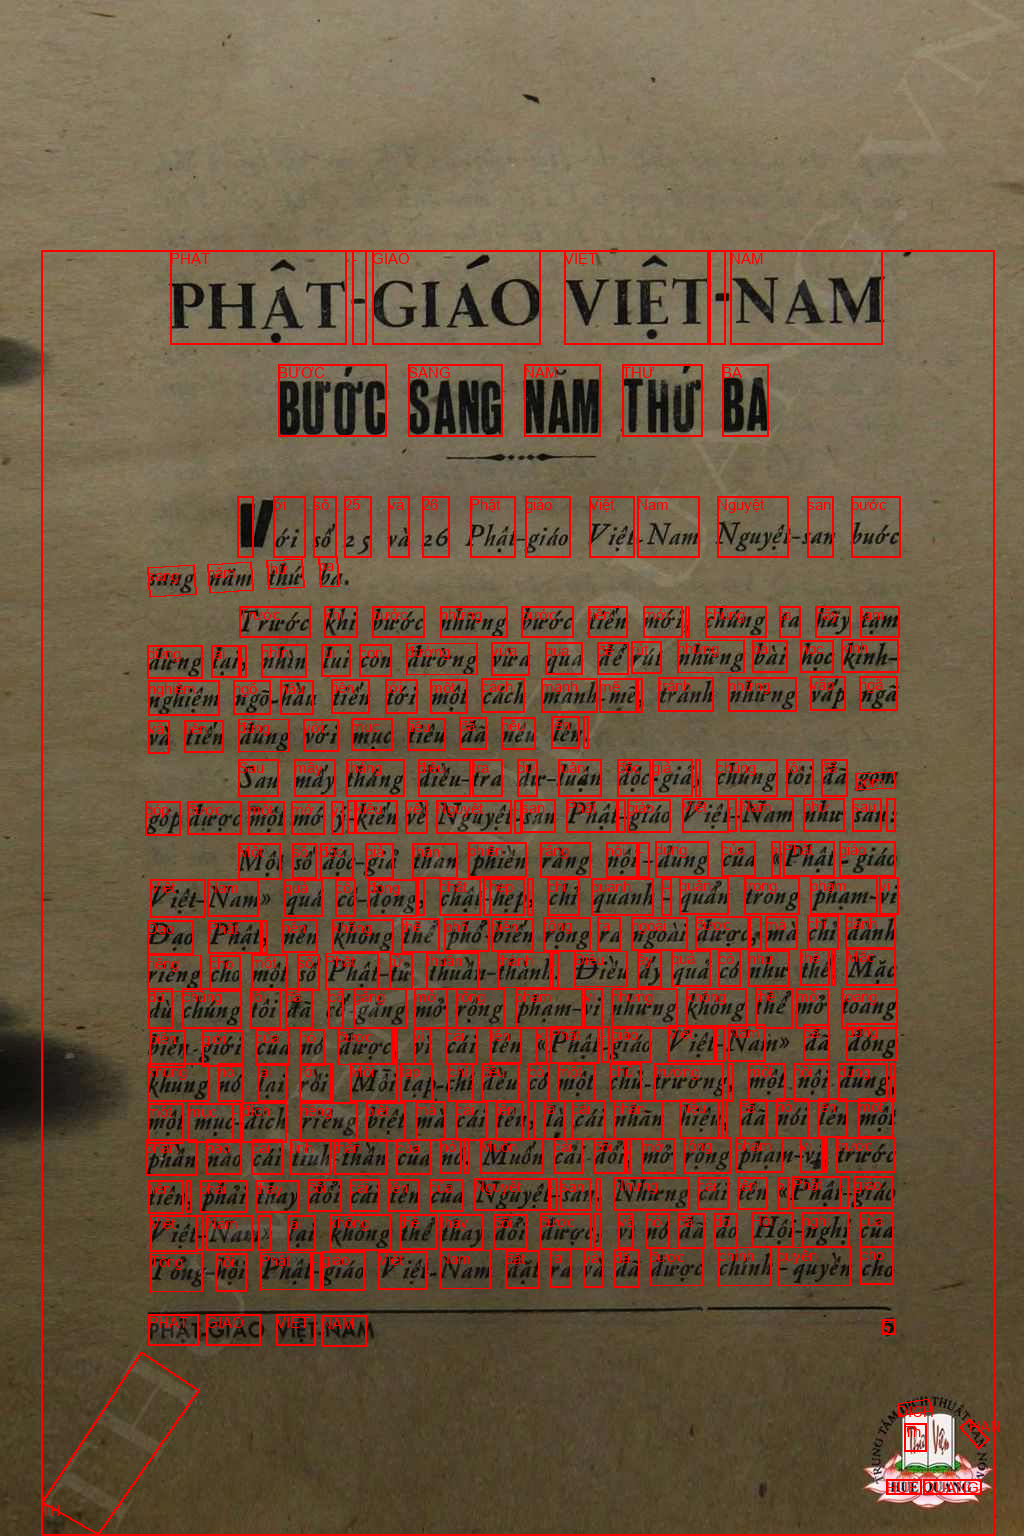

In [14]:
images[3]

In [38]:
new_info

[['PHẬT', (132, 124), 184, 420],
 ['GIÁO', (568, 124), 184, 344],
 ['VET', (124, 356), 120, 365],
 ['-', (501, 356), 120, 54],
 ['NAM', (574, 356), 120, 346],
 ['NGUYỆT', (385, 603), 48, 179],
 ['-', (566, 603), 48, 11],
 ['SÂN', (581, 603), 48, 82],
 ['SỐ', (132, 1390), 36, 42],
 ['1', (203, 1390), 36, 11],
 ['RA', (245, 1390), 36, 38],
 ['NGÀY', (310, 1390), 36, 96],
 ['15', (435, 1390), 36, 43],
 ['THÁNG', (505, 1390), 36, 116],
 ['8', (648, 1390), 36, 17],
 ['BÍNH', (693, 1390), 36, 80],
 ['THÂN', (803, 1390), 36, 83],
 ['CH', (904, 1390), 36, 44],
 ['TỔNG', (110, 1450), 45, 87],
 ['.', (210, 1450), 45, 7],
 ['HỘI', (231, 1450), 45, 53],
 ['PHẬT', (318, 1450), 45, 79],
 ['-', (402, 1450), 45, 13],
 ['GIÁO', (428, 1450), 45, 73],
 ['VIỆT', (539, 1450), 45, 61],
 ['-', (611, 1450), 45, 6],
 ['NAM', (631, 1450), 45, 73],
 ['XUẤT', (732, 1450), 45, 82],
 ['.', (820, 1450), 45, 12],
 ['The', (903, 1420), 30, 26],
 ['V', (928, 1420), 30, 19],
 ['HUỆ', (886, 1479), 15, 35],
 ['QUANG', (92

In [22]:
text_pages, marked_images = full_pdf_process(pdf_dir, "phat-giao-viet-nam-1956-25-26.pdf", output_dir)

beginning to process: ../PDF/Phat_Giao_journals/phat-giao-viet-nam-1956-25-26.pdf
processing page: 0...
processing page: 1...
processing page: 2...
processing page: 3...
processing page: 4...
processing page: 5...
processing page: 6...
processing page: 7...
processing page: 8...
processing page: 9...
processing page: 10...
processing page: 11...
processing page: 12...
processing page: 13...
processing page: 14...
processing page: 15...
processing page: 16...
processing page: 17...
processing page: 18...
processing page: 19...
processing page: 20...
processing page: 21...
processing page: 22...
processing page: 23...
processing page: 24...
processing page: 25...
processing page: 26...
processing page: 27...
Data successfully saved in ../processed_journal_data/phat-giao-viet-nam-1956-25-26
XML file successfully saved at ../processed_journal_data/phat-giao-viet-nam-1956-25-26/full_OCR_text_phat-giao-viet-nam-1956-25-26.xml


In [38]:
all_files =  os.listdir(pdf_dir)

In [42]:
all_files

['phat-giao-viet-nam-1956-15.pdf',
 'phat-giao-viet-nam-1956-01.pdf',
 'phat-giao-viet-nam-1956-28.pdf',
 'phat-giao-viet-nam-1956-14.pdf',
 'phat-giao-viet-nam-1956-02.pdf',
 'phat-giao-viet-nam-1956-16.pdf',
 'phat-giao-viet-nam-1956-20-21.pdf',
 'phat-giao-viet-nam-1956-03.pdf',
 'phat-giao-viet-nam-1956-07.pdf',
 'phat-giao-viet-nam-1956-13.pdf',
 'phat-giao-viet-nam-1956-12.pdf',
 'phat-giao-viet-nam-1956-04.pdf',
 'phat-giao-viet-nam-1956-11.pdf',
 'phat-giao-viet-nam-1956-05-06.pdf',
 'phat-giao-viet-nam-1956-09-10.pdf',
 'phat-giao-viet-nam-1956-17-18.pdf',
 'phat-giao-viet-nam-1956-25-26.pdf',
 'phat-giao-viet-nam-1956-23.pdf',
 'phat-giao-viet-nam-1956-22.pdf',
 'phat-giao-viet-nam-1956-27.pdf',
 'phat-giao-viet-nam-1956-19.pdf',
 'phat-giao-viet-nam-1956-24.pdf']

In [43]:
px_list = [all_files[2]] + all_files[6:16] + all_files[17:21]

In [44]:
px_list

['phat-giao-viet-nam-1956-28.pdf',
 'phat-giao-viet-nam-1956-20-21.pdf',
 'phat-giao-viet-nam-1956-03.pdf',
 'phat-giao-viet-nam-1956-07.pdf',
 'phat-giao-viet-nam-1956-13.pdf',
 'phat-giao-viet-nam-1956-12.pdf',
 'phat-giao-viet-nam-1956-04.pdf',
 'phat-giao-viet-nam-1956-11.pdf',
 'phat-giao-viet-nam-1956-05-06.pdf',
 'phat-giao-viet-nam-1956-09-10.pdf',
 'phat-giao-viet-nam-1956-17-18.pdf',
 'phat-giao-viet-nam-1956-23.pdf',
 'phat-giao-viet-nam-1956-22.pdf',
 'phat-giao-viet-nam-1956-27.pdf',
 'phat-giao-viet-nam-1956-19.pdf']

In [45]:
for filename in px_list:
        #print(filename)  # Do something with each file path
        full_pdf_process(pdf_dir, filename, output_dir)

beginning to process: ../PDF/Phat_Giao_journals/phat-giao-viet-nam-1956-28.pdf
processing page: 0...
processing page: 1...
processing page: 2...
processing page: 3...
processing page: 4...
processing page: 5...
processing page: 6...
processing page: 7...
processing page: 8...
processing page: 9...
processing page: 10...
processing page: 11...
processing page: 12...
processing page: 13...
processing page: 14...
processing page: 15...
processing page: 16...
processing page: 17...
processing page: 18...
processing page: 19...
processing page: 20...
processing page: 21...
processing page: 22...
processing page: 23...
processing page: 24...
processing page: 25...
processing page: 26...
processing page: 27...
processing page: 28...
processing page: 29...
processing page: 30...
processing page: 31...
processing page: 32...
processing page: 33...
processing page: 34...
processing page: 35...
processing page: 36...
processing page: 37...
processing page: 38...
processing page: 39...
processing 